## Import Relevant Packages / Libraries

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
import pandas as pd
pd.set_option('max_columns', 75)
import numpy as np 
import time
import seaborn as sns

# importing sklearn libraries

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt 

%matplotlib inline
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

import nltk
from nltk.stem import WordNetLemmatizer

### Importing Cleaned Data to be used for modeling

In [54]:
reddits = pd.read_csv('./reddits_cleaned_for_modeling.csv')

In [55]:
reddits

,target,selftext,title,word_count
0,1,2019 was probably one of the worst year of my ...,Hello 2020 and fuck you 2019.,49
1,1,I saw your post on this subreddit. I saw that ...,To my new hopeful friend on the other side of ...,114
2,1,"I feel like I've been hanging on by a thread, ...",can't imagine making it to 2030,60
3,1,blank post,Why do I have the strongest urge to jump out o...,2
4,1,I've been clean from self harm for over two ye...,Suicidal thoughts are so intense,104
...,...,...,...,...
3796,0,So i know a kid who threatened to shoot my sch...,School sucks,176
3797,0,Just dropped out of school. I realized that my...,Drop out,73
3798,0,"My anxiety tells me I'm worthless, and that p...",Having a hard time,180
3799,0,Last weekend I finally told my parents about m...,Finally seeing a doctor,96


# NLP Processing and Modeling

### Set X and Y Variables

In [56]:
X = reddits['selftext']
y = reddits['target']

### Lemmatizing, Creating a Logistic Regression Model and Gridsearching over the best parameters to use

In [57]:
# instantiate wordnet lemmatizer
lemmatizer = WordNetLemmatizer()

X_lem = [lemmatizer.lemmatize(i) for i in X]

# converting the lemmatized words (which is a list) to a pandas dataframe and will train_test_split
# using X_lem belwo
X_lem = pd.Series(i for i in X_lem)

In [58]:
# performing a new train test split
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y, random_state=78758, 
                                                   test_size=0.33,
                                                    stratify=y,)

In [59]:
# creating a pipe and grid search for various logistic regression parameters
pipe_logreg = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('logreg', LogisticRegression(solver='liblinear'))
])

pipe_params_logreg = {'logreg__C': [1, 20, 1/10, 1, 10, 20], # setting various alphas
                 'logreg__penalty': ['l1', 'l2'] # default penalty is 'l2' for application of ridge regression
                      # 'l1' to consider lasso regression
                      
}

gs_logreg = GridSearchCV(pipe_logreg, pipe_params_logreg, cv=5)

In [60]:
t0= time.time()
gs_logreg.fit(X_train_lem, y_train_lem)
print(f'It took {round(time.time() - t0, 4)} seconds for the model to run') 

gs_model_logreg = gs_logreg.best_estimator_
print(gs_model_logreg)

It took 62.3716 seconds for the model to run
Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logreg',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_

In [61]:
# score on training data set with gs_model_logreg
gs_model_logreg.score(X_train_lem, y_train_lem)

0.9520816967792616

In [62]:
# score on test data set with gs_model_logreg
gs_model_logreg.score(X_test_lem, y_test_lem)

0.8454183266932271

In [63]:
predictions_gs_logreg = gs_model_logreg.predict(X_test_lem)

# Building a confusion matrix for the gs_model
pd.DataFrame(confusion_matrix(y_test_lem, predictions_gs_logreg), 
             columns=['Prediction: Anxiety', 'Prediction: Depression'],
             index= ['Actual: Anxiety', 'Actual: Depression'])

,Prediction: Anxiety,Prediction: Depression
Actual: Anxiety,526,117
Actual: Depression,77,535


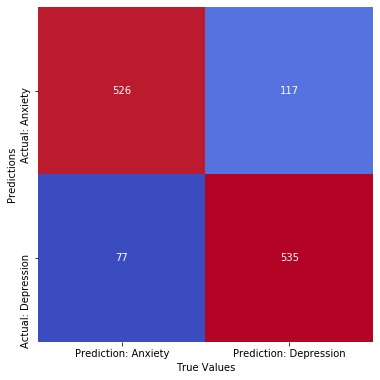

In [64]:
plt.figure(figsize=(6,8))
cm = confusion_matrix(y_test_lem, predictions_gs_logreg)
sns.heatmap(cm, square=True, annot=True, cbar=False, fmt='g', cmap='coolwarm',
xticklabels=['Prediction: Anxiety', 'Prediction: Depression'],
            yticklabels=['Actual: Anxiety', 'Actual: Depression'])
plt.xlabel('True Values')
plt.ylabel('Predictions');

### Creating a Logistic Regression Model and Gridsearching over the best parameters WITHOUT Lemmatization

In [65]:
X = reddits['selftext']
y = reddits['target']

In [66]:
# performing a new train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30303, 
                                                    stratify=y,)

In [67]:
# creating a pipe and grid search for various logistic regression parameters
pipe_logreg = Pipeline([
   
    ('logreg', LogisticRegression(solver='liblinear'))
])

pipe_params_logreg = {'logreg__C': [1, 20, 1/10, 1, 10, 20], # setting various alphas
                 'logreg__penalty': ['l1', 'l2'] # default penalty is 'l2' for application of ridge regression
                      # 'l1' to consider lasso regression
                      
}

gs_logreg = GridSearchCV(pipe_logreg, pipe_params_logreg, cv=5)

In [68]:
cvec = CountVectorizer()
cvec.fit(X_train)

# Transform the corpus.
X_train_cvec = cvec.transform(X_train)

# Transform test
X_test_cvec = cvec.transform(X_test)

t0= time.time()
gs_logreg.fit(X_train_cvec, y_train)
print(f'It took {round(time.time() - t0, 4)} seconds for the model to run') 

It took 25.0089 seconds for the model to run


In [69]:
gs_model_logreg = gs_logreg.best_estimator_
gs_model_logreg

Pipeline(memory=None,
         steps=[('logreg',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [70]:
# score on training data set with gs_model_logreg
gs_model_logreg.score(X_train_cvec, y_train)

0.9543859649122807

In [71]:
# score on testing data set with gs_model_logreg
gs_model_logreg.score(X_test_cvec, y_test)

0.8380651945320715

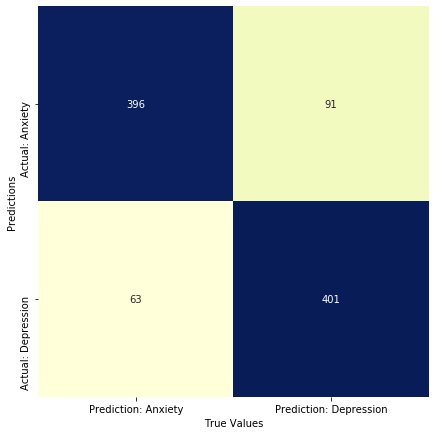

In [72]:
predictions_gs_logreg = gs_model_logreg.predict(X_test_cvec)

plt.figure(figsize=(7,9))
cm = confusion_matrix(y_test, predictions_gs_logreg)
sns.heatmap(cm, square=True, annot=True, cbar=False, fmt='g', cmap='YlGnBu',
xticklabels=['Prediction: Anxiety', 'Prediction: Depression'],
            yticklabels=['Actual: Anxiety', 'Actual: Depression'])
plt.xlabel('True Values')
plt.ylabel('Predictions');

In [87]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(predictions_gs_logreg, columns=['predicted'])

# Create column for observed values.
results['actual'] = y_test.values
# add original text to the results df
results['text'] = X_test.values
# creating a 'correct' column
results['correct'] = results['actual'] == results['predicted']

# evaluating the errors
results[results['correct'] == False]

,predicted,actual,text,correct
0,1,0,Im so excited good god,False
2,0,1,Seemed okay at first when I went to the doughn...,False
8,0,1,"We got into a fight last night, and it hurt ou...",False
9,1,0,"I've pain at several of my joints : knees, elb...",False
15,0,1,"Hello everyone!\nI've been diagnosed with BPD,...",False
...,...,...,...,...
933,1,0,I think I am. I don’t know what it is yet thou...,False
938,1,0,I go back to college tomorrow and I don’t want...,False
941,1,0,I’ve finally been referred for CBT in my area....,False
944,1,0,"I hate them, too. But this time, they really ...",False


In [91]:
subset = results[(results['correct'] == False) & (results['predicted'] ==1)]
subset.head(25)

,predicted,actual,text,correct
0,1,0,Im so excited good god,False
9,1,0,"I've pain at several of my joints : knees, elb...",False
16,1,0,"So here's the rundown, I used to love cartoons...",False
18,1,0,"What is the easiest, painless way to kill myself?",False
23,1,0,Struggling.\n\nDelusions.\n\nTough.\n\nIt is r...,False
34,1,0,I'm not really sure what I'm posting for. Vent...,False
47,1,0,"Hello everyone, I'm a 16-year-old boy and rece...",False
67,1,0,I've always been obsessed with how quickly tim...,False
72,1,0,"Hi, \n\nMy(23f) fiance (28m) is an athlete. He...",False
86,1,0,Hello! \n\n*Sorry for this post. I'm venting a...,False


In [75]:
# example of a post that was predicted 'anxiety' but was actually 'depression'
results['text'].loc[933]

'I think I am. I don’t know what it is yet though. The universe? I know that seems crazy but it’s the only thing that’s ever made sense to me. So for now, I will put my trust into the universe and know that it has a plan. \nI am just one very small part of this grand with the ability to make huge waves. I am the ocean. I am not sure if I’m experiencing the calm before or after the storm. But I know that there was a storm. A big one. And it was ugly. It must be after. Man, I hope it’s after.'

In [95]:
results['text'].loc[184]

"Around 8 months ago I had a pretty private mental breakdown, quit seeing my therapist and ghosted every single one of my friends. I've just thought i was a major loser ever since i dropped out 2 yrs ago and shit keeps going down hill. I don't consider myself to have bad self esteem or even to be depressed since this breakdown; I just see myself for who I am now. Regardless I cry daily at the drop of the hat and my anxiety can be so severe that I sleep in the stairwell of my apartment complex for weeks to avoid my roommates. Life with no one to talk to or hang out with has changed me into an alien.  I still laugh at youtube and memes and have semi-meaningful conversations but I don't feel like I can feel emotion like I used to. Long bouts of staying in bed crying or smoking weed and drinking used to be my way of coping, but since ghosting everyone I have no way of even getting alchohol so I just work and sleep. Nothing matters. I'm not sure what this would be considered and I'm wonderi

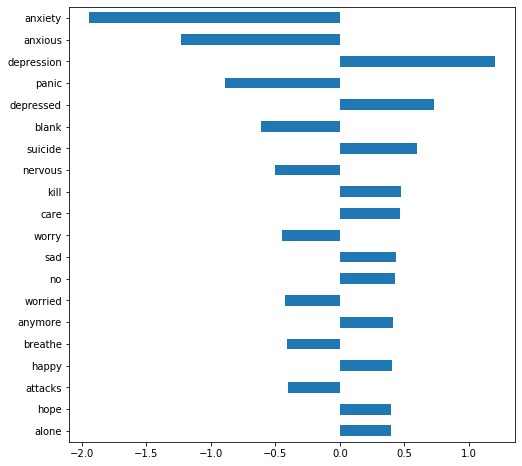

In [26]:
# setting a logistic regression variable as grid search does not hav a coef object
logreg_coef = gs_logreg.best_estimator_.named_steps.logreg.coef_

fig , ax = plt.subplots(figsize=(8,8))

coef_df = pd.DataFrame(logreg_coef, columns=cvec.get_feature_names()).T
coef_df['ABS'] = coef_df[0].abs()
coef_df.sort_values('ABS').tail(20).loc[:,0].plot.barh(ax=ax);

## Model with TFIDF Vectorizer and Gaussian Bayes

In [27]:
# performing a new train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10011, 
                                                    stratify=y,)

In [28]:
tvec = TfidfVectorizer()
tvec.fit(X_train, y_train)

X_train_tvec = tvec.transform(X_train).todense()
X_test_tvec = tvec.transform(X_test).todense()

In [29]:
# Instantiate Gaussian Naive Bayes model.
gnb = GaussianNB()

# fit TfidfVectorized() variables to the Gaussian Bayes model
gnb.fit(X_train_tvec, y_train)

print(f'Training accuracy score for our Gaussian Naive Bayes model is: \
{round(gnb.score(X_train_tvec, y_train),4)}.')
print()
print(f'Testing accuracy score for our Gaussian Naive Bayes model is: {round(gnb.score(X_test_tvec, y_test),4)}.')

Training accuracy score for our Gaussian Naive Bayes model is: 0.9396.

Testing accuracy score for our Gaussian Naive Bayes model is: 0.6393.


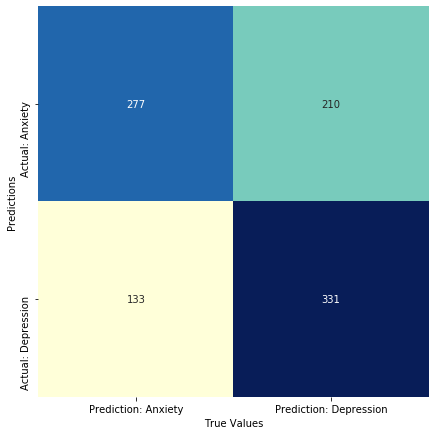

In [30]:
gnb_predictions = gnb.predict(X_test_tvec)

plt.figure(figsize=(7,9))
cm = confusion_matrix(y_test, gnb_predictions)
sns.heatmap(cm, square=True, annot=True, cbar=False, fmt='g', cmap='YlGnBu',
xticklabels=['Prediction: Anxiety', 'Prediction: Depression'],
            yticklabels=['Actual: Anxiety', 'Actual: Depression'])
plt.xlabel('True Values')
plt.ylabel('Predictions');

In [31]:
## what posts were misclassified?
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gnb.predict(X_test_tvec), columns=['predicted'])

# Create column for observed values.
results['actual'] = y_test.values
# add original text to the results df
results['text'] = X_test.values
# creating a 'correct' column
results['correct'] = results['actual'] == results['predicted']

# evaluating the errors
results[results['correct'] == False]

,predicted,actual,text,correct
2,1,0,I’m sixteen. Junior in high school. Last week ...,False
5,1,0,So I start a new job tomorrow (I guess today a...,False
6,0,1,"Idk, these past few weeks I’ve been thinking a...",False
7,0,1,"I remember when i was happy, i remember waking...",False
8,0,1,"I feel like I've been hanging on by a thread, ...",False
...,...,...,...,...
939,1,0,Sorry for the wall of text! I tried to make it...,False
943,1,0,blank post,False
944,0,1,"I realised that with depression , I rarely get...",False
947,1,0,I'm back at work today after the long Thanksgi...,False


In [32]:
# example of a post that was predicted 'anxiety' but was actually 'depression'
results['text'].loc[938]

'Some days, especially days I’m off of work I have little to no motivation. Personally, I just want to hop in the car and drive to walk into a store without having taken a shower and being a complete mess. It started out with my feelings getting hurt unintentionally through a phone call which lead me to tears. I’m on medication which seems to work on my good days lol. Anyway, I’m hoping I’ll be able to get up from this chair and get outside'

### SKLearn Bagging 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10003)

In [34]:
bag = BaggingClassifier(random_state=42)
cvec = CountVectorizer()
cvec.fit(X_train)

X_train_cvec = cvec.transform(X_train).todense()
X_test_cvec = cvec.transform(X_test).todense()

In [35]:
# Fit BaggingClassifier.
bag.fit(X_train_cvec, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=42, verbose=0,
                  warm_start=False)

In [36]:
print(f'Training accuracy score for our Bagging Classifier model is: \
{round(bag.score(X_train_cvec, y_train),4)}.')
print()
print(f'Testing accuracy score for our Bagging Classifier model is: {round(bag.score(X_test_cvec, y_test),4)}.')

Training accuracy score for our Bagging Classifier model is: 0.9765.

Testing accuracy score for our Bagging Classifier model is: 0.8191.


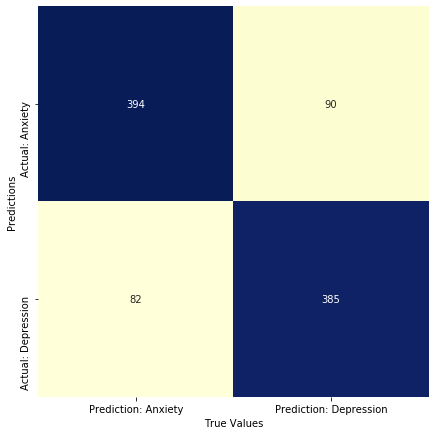

In [37]:
bag_predictions = bag.predict(X_test_cvec)

plt.figure(figsize=(7,9))
cm = confusion_matrix(y_test, bag_predictions)
sns.heatmap(cm, square=True, annot=True, cbar=False, fmt='g', cmap='YlGnBu',
xticklabels=['Prediction: Anxiety', 'Prediction: Depression'],
            yticklabels=['Actual: Anxiety', 'Actual: Depression'])
plt.xlabel('True Values')
plt.ylabel('Predictions');

In [38]:
# Create DataFrame with column for predicted values.
results_bag = pd.DataFrame(bag_predictions, columns=['predicted'])

# Create column for observed values.
results_bag['actual'] = y_test.values
# add original text to the results df
results_bag['text'] = X_test.values
# creating a 'correct' column
results_bag['correct'] = results_bag['actual'] == results_bag['predicted']

# evaluating the errors
results_bag[results_bag['correct'] == False]

,predicted,actual,text,correct
4,0,1,literally feels like a mesh or infection aroun...,False
15,1,0,I have a friend who plays football at a divisi...,False
18,0,1,"I thought everyone have the same experiences, ...",False
29,0,1,Last academic year I had a disability plan at ...,False
32,1,0,Today was my final straw for my family and we'...,False
...,...,...,...,...
904,1,0,in two years since I have been on lexapro I ha...,False
906,0,1,so many people are disappointed in me and it m...,False
929,0,1,blank post,False
939,0,1,So this started about 6 months ago. I’m not su...,False


In [39]:
results_bag['text'].loc[941]

'I\'m pretty good on keeping my depression under wraps. I can feel joy and I\'m usually not super depressed, but its honestly got to me today.\n\nI have a few Best Friends. Two here, and one in Chicago. I can\'t go to Chicago, obviously, seeing that I live hours away. The other two are at parties of their own, and I haven\'t gotten a text from the one in Chicago. \n\nI feel very alone. And its scares me. I feel like a pansy saying that, seeing that I\'m such a big guy with a lot of care. I want to tell them "Hey I\'m not doing very well." But they\'re all drunk or high and I can\'t actually get my thoughts across to them. \n\nHelp.'

In [40]:
results_bag['text'].loc[949]

"Sorry to rant a bit..\n\nI'm trying really hard not to take it personally.. but I just need someone to reassure me that it is just because of depression. Shes been struggling with it for a long time, some days she'll be really affectionate and loving and talk about our future together, then other days she'll not text me till later in the day and will go play video games with other people. I struggle a bit with insecurity too as Im jealous shes hanging with other guys during the day while Im stuck doing homework while she barely replies to me. Our relationship is LDR and when things are good (like the other day) she calls me her soulmate and talks about a family someday and living together. But when she gets depressed and grows distant, I cant help but feel a bit hurt and lonely.. Then I see her playing games with other guys and I get insecure. I told her today that I love her a lot, and she doesn't have to worry about talking to me, as I want her to do what she needs to do to feel bet